# Training a model

This notebook takes input TTrees that contain event-level branches and classifies between different groups of events.

## Preparing the dataframe

In [1]:
import os, sys
import numpy as np
import uproot
import pandas as pd

In [2]:
#Global parameters:
indir = '../../input_trees/ForTraining/'
chno = 0 #mumu 

In [3]:
#Given a TFile, read its branches into a dataframe.
def read_file_into_df(filepath, truth):

    filename = filepath.split('/')[-1]
    sample = filename.split("_")[1]
    subsample = "_".join(filename.split("_")[2:])
    
    #Exceptions
    if 'QCD' in filename or 'VLL' in filename:
        sample = filename.split("_")[1]+"_"+filename.split("_")[2]
        subsample = filename.split("_")[3].split(".")[0]
        
    if subsample.endswith(".root"): subsample = subsample[:-5]

    tfile = uproot.open(filepath)
    ttree = tfile['myEvents']
    branches = ttree.keys()
    awkarray = ttree.arrays(branches)
    df = pd.DataFrame(awkarray.to_list())
    df['truth'] = truth
    df['sample'] = sample
    df['subsample'] = subsample

    #print(f'dataframe for {sample} {subsample} loaded.')
    return df

def prepare_df(jobname, samples, truth):
    print(f'Picking files from {os.path.join(indir, jobname)}')
    dfout = pd.DataFrame()
    for s in samples:
        files = os.listdir(f'{indir}/{jobname}')
        for f in files:
            if s not in f: continue
            filepath = os.path.join(indir, jobname, f)
            df = read_file_into_df(filepath, truth)
            if 'channel' in df.columns:
                df = df[df['channel'] == chno]  # Filtering by channel
                dfout = pd.concat([dfout, df], ignore_index=True)
                print(f"dataframe for {f} loaded.")
            else:
                print(f"\033[0;31mWarning: 'channel' column not found in {f}. Skipping this file.\033[0m")
            
    return dfout

print('Functions loaded.')

Functions loaded.


### Reading the trees into dataframes

In [4]:
%%time

bkgsamples = ['QCD_MuEnriched']
sigsamples = ['VLLD_mu_M100', 'VLLD_mu_M200', 'VLLD_mu_M300', 'VLLD_mu_M400', 'VLLD_mu_M600', 'VLLD_mu_M800']

bkgdf = prepare_df('tree_2016preVFPUL_2LSSmm_Sept23', bkgsamples, 0)
sigdf = prepare_df('tree_2018UL_2LSSmm_Sept23', sigsamples, 1)

print('\033[1;32mDone reading samples.\033[0m\n')

Picking files from ../../input_trees/ForTraining/tree_2016preVFPUL_2LSSmm_Sept23
dataframe for tree_QCD_MuEnriched_120to170.root loaded.
dataframe for tree_QCD_MuEnriched_170to300.root loaded.
dataframe for tree_QCD_MuEnriched_20to30.root loaded.
dataframe for tree_QCD_MuEnriched_300to470.root loaded.
dataframe for tree_QCD_MuEnriched_30to50.root loaded.
dataframe for tree_QCD_MuEnriched_470to600.root loaded.
dataframe for tree_QCD_MuEnriched_50to80.root loaded.
dataframe for tree_QCD_MuEnriched_600to800.root loaded.
dataframe for tree_QCD_MuEnriched_800to1000.root loaded.
dataframe for tree_QCD_MuEnriched_80to120.root loaded.
Picking files from ../../input_trees/ForTraining/tree_2018UL_2LSSmm_Sept23
dataframe for tree_VLLD_mu_M100.root loaded.
dataframe for tree_VLLD_mu_M200.root loaded.
dataframe for tree_VLLD_mu_M300.root loaded.
dataframe for tree_VLLD_mu_M400.root loaded.
dataframe for tree_VLLD_mu_M600.root loaded.
dataframe for tree_VLLD_mu_M800.root loaded.
Done reading samples

In [5]:
df = pd.concat([sigdf, bkgdf])
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]
print(df.keys())
print(f'Signal and background before filtering: {nsig}, {nbkg}')

Index(['channel', 'nlep', 'njet', 'nbjet', 'lep0_pt', 'lep0_eta', 'lep0_phi',
       'lep0_iso', 'lep0_sip3d', 'lep0_mt', 'lep1_pt', 'lep1_eta', 'lep1_phi',
       'lep1_iso', 'lep1_sip3d', 'lep1_mt', 'dilep_pt', 'dilep_eta',
       'dilep_phi', 'dilep_mass', 'dilep_mt', 'dilep_deta', 'dilep_dphi',
       'dilep_dR', 'dilep_ptratio', 'HT', 'LT', 'STvis', 'ST', 'HTMETllpt',
       'STfrac', 'metpt', 'metphi', 'dphi_metlep0', 'dphi_metlep1',
       'dphi_metdilep', 'dphi_metlep_max', 'dphi_metlep_min', 'jec', 'jer',
       'wt_leptonSF', 'wt_trig', 'wt_bjet', 'weight', 'truth', 'sample',
       'subsample'],
      dtype='object')
Signal and background before filtering: 10936, 317263


### Filtering the dataframe

In [6]:
df = df.query('lep0_iso < 1.0 and lep1_iso < 1.0')
nsig = df[df['truth'] == 1].shape[0]
nbkg = df[df['truth'] == 0].shape[0]
print(f'Signal and background after filtering: {nsig}, {nbkg}')

Signal and background after filtering: 7026, 12070


In [7]:
df

,channel,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,lep0_mt,...,dphi_metlep_min,jec,jer,wt_leptonSF,wt_trig,wt_bjet,weight,truth,sample,subsample
0,0,2,1,0,33.108379,0.696167,2.029297,0.000000,0.596680,52.223152,...,1.284439,1.0,0.984047,0.955288,0.950463,0.941926,0.907966,1,VLLD_mu,M100
1,0,2,0,0,28.225590,1.917725,-2.783203,0.000000,0.286621,116.076790,...,2.013672,1.0,1.000000,0.995077,0.953162,1.000000,0.948469,1,VLLD_mu,M100
2,0,2,1,0,116.545647,-2.343750,1.238770,0.000000,0.839844,337.821991,...,0.026367,1.0,0.997384,0.932034,0.997680,0.866455,0.929871,1,VLLD_mu,M100
3,0,2,2,0,26.424644,-1.337158,0.471313,0.127494,1.000977,158.208374,...,1.655256,1.0,0.892197,0.965247,0.950461,0.820153,0.917430,1,VLLD_mu,M100
5,0,2,2,0,106.932434,0.535400,-1.694336,0.006493,0.101318,75.159088,...,0.895508,1.0,1.013421,0.991395,0.950463,0.882938,0.942284,1,VLLD_mu,M100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317234,0,2,2,1,26.424759,-2.219727,-1.982178,0.117355,6.675781,156.412994,...,1.229492,1.0,1.035847,0.974236,0.953102,0.954973,0.928546,0,QCD_MuEnriched,80to120
317241,0,2,0,0,60.664322,-1.610107,1.554199,0.457455,0.678711,135.545700,...,0.100342,1.0,1.000000,0.969581,0.997806,1.000000,0.967454,0,QCD_MuEnriched,80to120
317242,0,2,0,0,42.580597,0.506226,2.689453,0.905165,10.546875,29.477510,...,0.891095,1.0,1.000000,0.982674,0.997546,1.000000,0.980263,0,QCD_MuEnriched,80to120
317251,0,2,2,0,34.039131,-2.033203,-0.220673,0.512905,10.554688,8.150005,...,0.108063,1.0,1.009430,0.999648,0.953162,1.000000,0.952826,0,QCD_MuEnriched,80to120


### Exploring the variables

In [8]:
import matplotlib.pyplot as plt
import math
os.makedirs('plots', exist_ok=True)

def latexname(var, alias): return alias.get(var, var) #Either get the latexname, or return the default name.

def plot_in_group(listvar, figname, suptitle=None, alias=None):
    num_vars = len(listvar)
    ncols = 4
    nrows = math.ceil(num_vars / ncols)
    vertical_size = nrows * 2.5
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(12, vertical_size))
    ax = ax.flatten()
    
    decorate_hist = {
        'bins':'auto',
        'histtype':'step',
        'linewidth':1.5,
        'density':True,
        'log':False
    }
    
    for i, var in enumerate(listvar):        
        sigdata = df[df['truth'] == 1][var]
        bkgdata = df[df['truth'] == 0][var]
        nsig = len(sigdata)
        nbkg = len(bkgdata)
        ax[i].hist(sigdata, label=f'sig [{nsig}]', color='xkcd:green', **decorate_hist)
        ax[i].hist(bkgdata, label=f'bkg [{nbkg}]', color='xkcd:blue',  **decorate_hist)
        if not alias: ax[i].set_title(var, fontsize=10)
        else: ax[i].set_title(latexname(var, alias), fontsize=10)
        ax[i].legend(loc='best', fontsize=8)
        ax[i].tick_params(axis='both', labelsize=6)
    
    for j in range(i+1, len(ax)): fig.delaxes(ax[j])

    if suptitle: fig.suptitle(suptitle, fontsize=12)
    
    
    plt.tight_layout()
    plt.savefig(f'plots/{figname}.png', dpi=300)
    plt.show()

print('Ready to plot!')

Ready to plot!


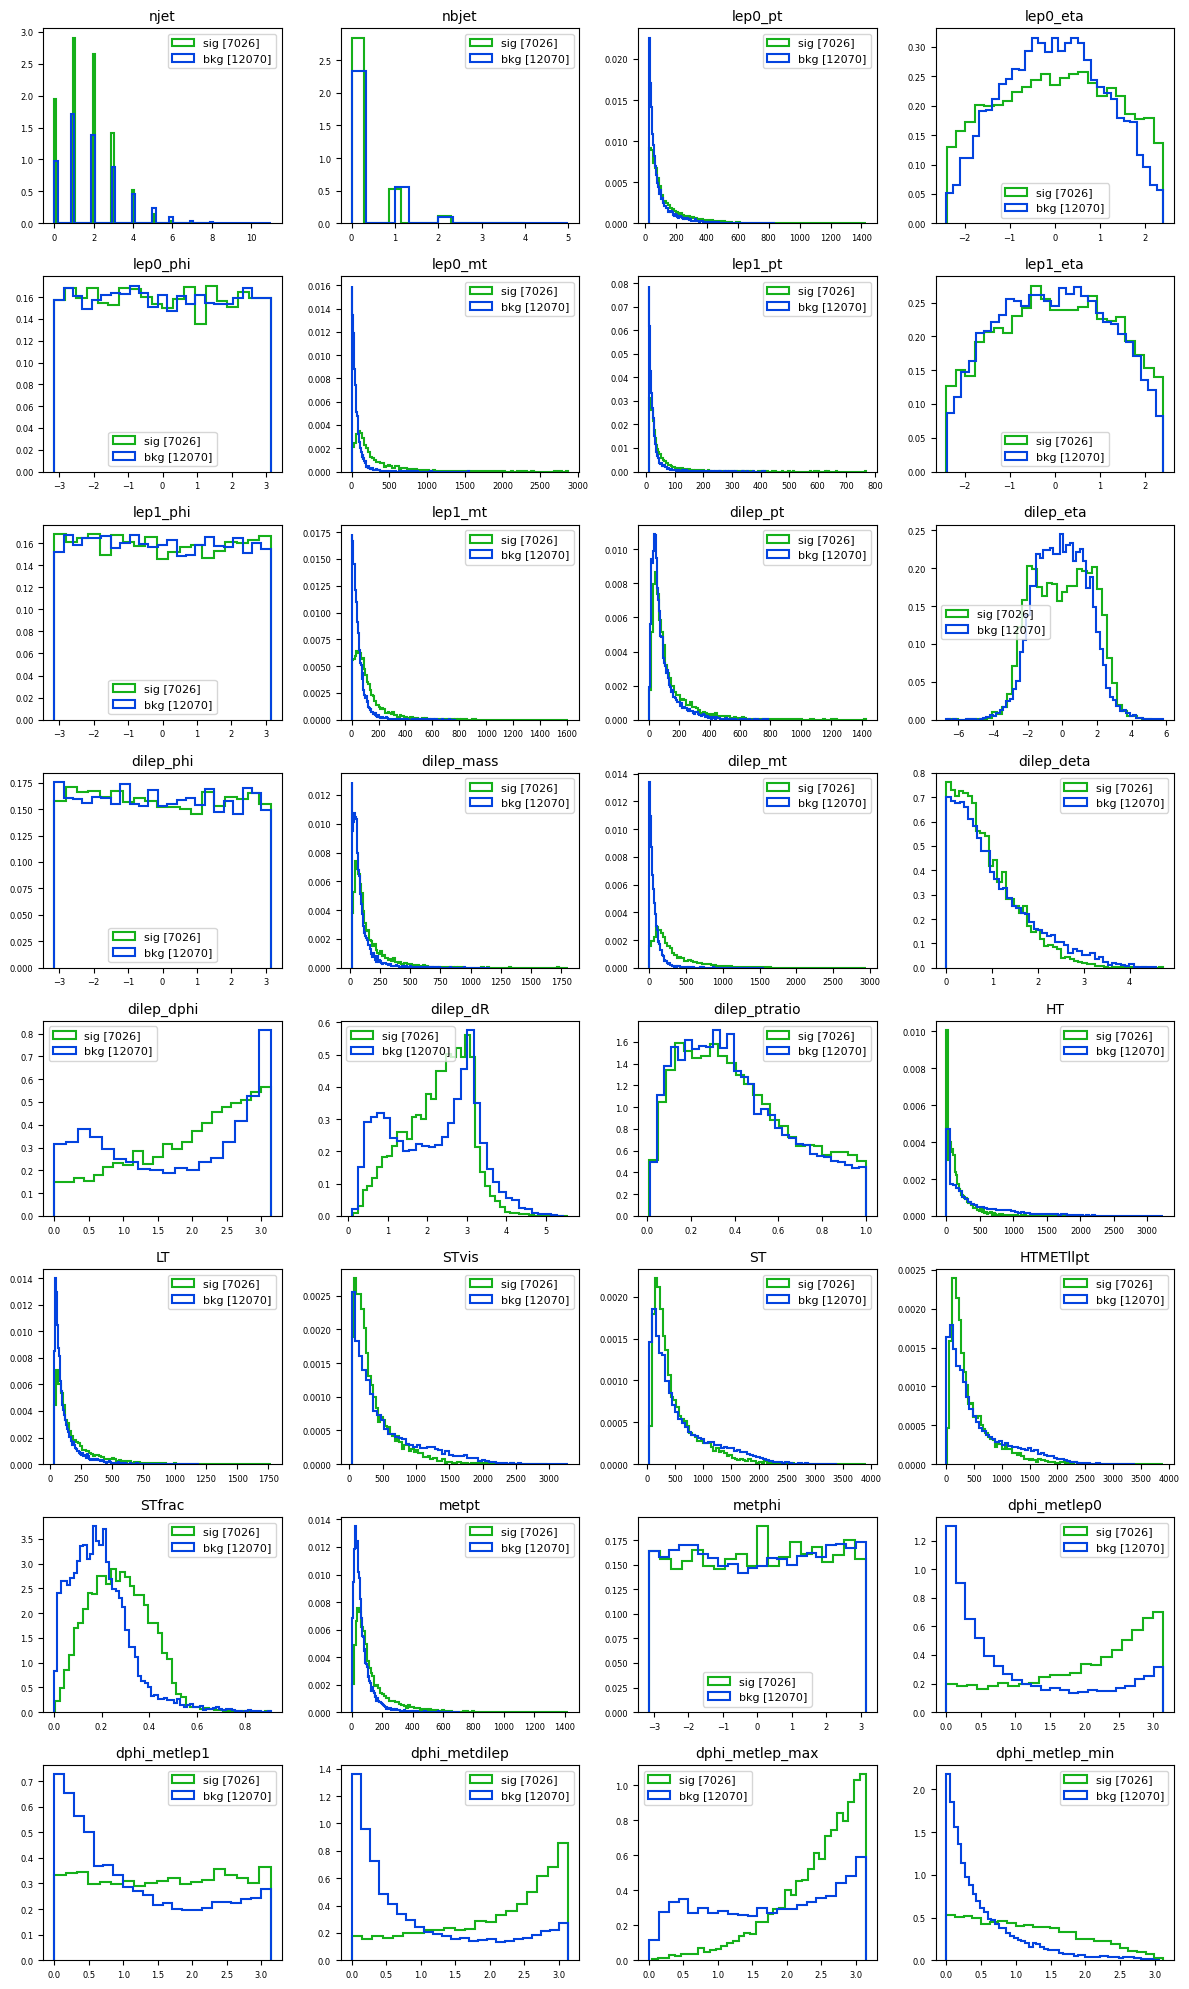

In [9]:
allvar = list(df.keys())

skipvar = ['channel', 'nlep', 'lep0_iso', 'lep0_sip3d', 'lep1_iso', 'lep1_sip3d',
           'jec', 'jer','wt_leptonSF', 'wt_trig', 'wt_bjet', 'weight', 'truth', 'sample', 'subsample']
plotvar = [var for var in allvar if var not in skipvar]

plot_in_group(plotvar, 'exploring_all_var')

### Deciding which variables to train on

The following input variables are chosen.
njet                $N_{\text{J}}$
dilep_mt            $M_{T}^{\text{  LL}}$
dilep_dR            $\Delta R(L_{0}, L_{1})$
dilep_dphi          $\Delta\phi(L_{0}, L_{1})$
HTMETllpt           $H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$
HT                  $H_{T}$
STfrac              $S_{T}^{\text{  frac}}$
dphi_metlep0        $\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$
dphi_metdilep       $\Delta\phi(LL, p_{T}^{\text{  miss}})$
dphi_metlep_max     $max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$
dphi_metlep_min     $min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$


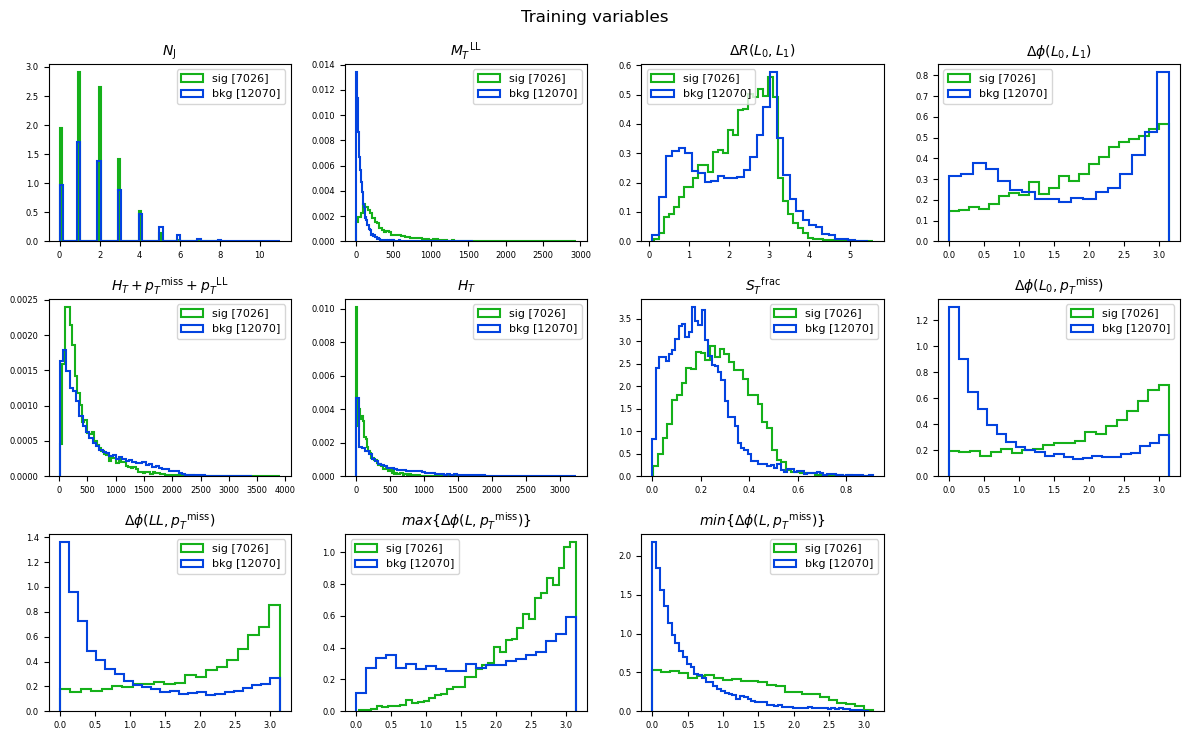

In [10]:
train_var = [
    'njet',
    'dilep_mt',
    'dilep_dR',
    'dilep_dphi',
    'HTMETllpt',
    'HT',
    'STfrac',
    'dphi_metlep0',
    'dphi_metdilep',
    'dphi_metlep_max',
    'dphi_metlep_min'
]

alias_ = {
    'njet':            r'$N_{\text{J}}$',
    'dilep_mt':        r'$M_{T}^{\text{  LL}}$',
    'dilep_dR':        r'$\Delta R(L_{0}, L_{1})$',
    'dilep_dphi':      r'$\Delta\phi(L_{0}, L_{1})$',
    'HTMETllpt':       r'$H_{T}+p_{T}^{\text{  miss}}+ p_T^{\text{  LL}}$',
    'HT':              r'$H_{T}$',
    'STfrac':          r'$S_{T}^{\text{  frac}}$',
    'dphi_metlep0':    r'$\Delta\phi(L_{0}, p_{T}^{\text{  miss}})$',
    'dphi_metdilep':   r'$\Delta\phi(LL, p_{T}^{\text{  miss}})$',
    'dphi_metlep_max': r'$max\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$',
    'dphi_metlep_min': r'$min\{\Delta\phi(L, p_{T}^{\text{  miss}})\}$'
} #Uses these names in plot. If not mentioned here, uses the dafault name.

print('The following input variables are chosen.')
for var in train_var: print(f"{var:<20}{latexname(var, alias_)}")

plot_in_group(train_var, 'training_varriables', suptitle='Training variables', alias=alias_)

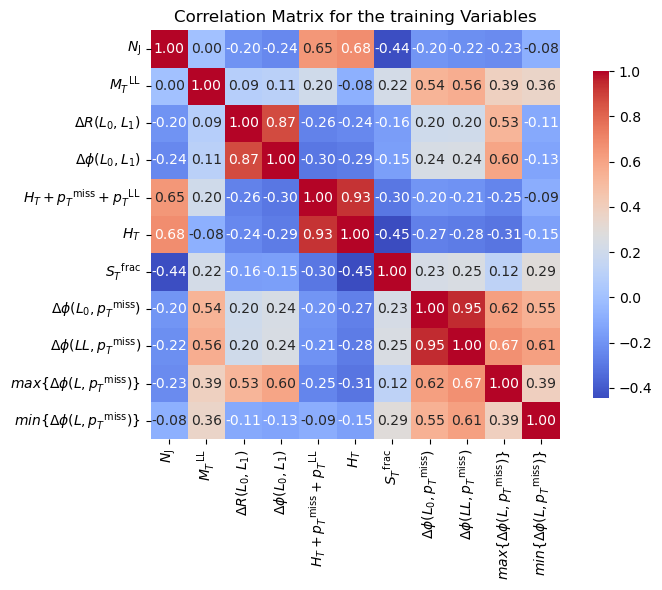

In [11]:
import seaborn as sns

correlation_data = df[train_var]
correlation_matrix = correlation_data.corr()

fig, ax = plt.subplots(figsize=(8, 6))

#sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
#            cbar_kws={"shrink": .8}, ax=ax, xticklabels=train_var, yticklabels=train_var)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, 
            cbar_kws={"shrink": .8}, ax=ax, 
            xticklabels=[latexname(var, alias_) for var in train_var],  # Use LaTeX aliases for x-axis labels
            yticklabels=[latexname(var, alias_) for var in train_var])  # Use LaTeX aliases for y-axis labels

ax.set_title('Correlation Matrix for the training Variables', fontsize=12)

plt.tight_layout()
plt.savefig('plots/correlation_trainvar.png', dpi=300, bbox_inches='tight')
plt.show()

## Preparing the Neural Network

In [12]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

2024-09-26 17:11:56.106655: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
modelname = 'QCD-VLLD_mu-classifier'
os.makedirs(modelname, exist_ok=True)

### Training and testing dataset

In [14]:
df = df.sample(frac=1).reset_index(drop=True)
df_train, df_test = train_test_split(df, test_size=0.3, stratify=df['truth'])

#Randomizing again:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test  = df_test.sample(frac=1).reset_index(drop=True)

nsig_train = len(df_train.query('truth == 1'))
nsig_test  = len(df_test.query('truth == 1'))
nbkg_train = len(df_train.query('truth == 0'))
nbkg_test  = len(df_test.query('truth == 0'))

print(f'Statistics:')
print(f'nSig split into train and test: {nsig_train}, {nsig_test}')
print(f'nBkg split into train and test: {nbkg_train}, {nbkg_test}')

Statistics:
nSig split into train and test: 4918, 2108
nBkg split into train and test: 8449, 3621


### Min-max scaling

In [15]:
def FindMinMax(X, modelname):
    # Calculate min and max values
    maxval = X.max(axis=0)
    minval = X.min(axis=0)
    print('\n' + '-' * 25)
    print("Min Values found: ", minval)
    print("Max Values found: ", maxval)
    
    # Save min and max values to separate text files without headers
    np.savetxt(f'{modelname}/scaling_parameters_min.txt', minval, fmt='%.6f')
    np.savetxt(f'{modelname}/scaling_parameters_max.txt', maxval, fmt='%.6f')

def ApplyMinMax(X, min_filename, max_filename):
    # Load min values from the file
    minval = np.loadtxt(min_filename)
    
    # Load max values from the file
    maxval = np.loadtxt(max_filename)
    
    #print('Min from txt: ', minval)
    #print('Max from txt: ', maxval)
    
    # Calculate the difference
    diff = maxval - minval
    normed_X = X.copy()    
    # Scale the data only for non-constant columns
    nonconst = np.where(diff != 0)[0]
    normed_X[:, nonconst] = 2 * ((X[:, nonconst] - minval[nonconst]) / diff[nonconst]) - 1.0
    
    return normed_X

print('Functions for min-max scaling ready.')

Functions for min-max scaling ready.


In [16]:
#Numpy arrays that go into the training and testing:
X_train= df_train[train_var].values
y_train= df_train['truth'].values
X_test = df_test[train_var].values
y_test = df_test['truth'].values

FindMinMax(X_train, modelname)

X_train = ApplyMinMax(X_train, f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')
X_test  = ApplyMinMax(X_test,  f'{modelname}/scaling_parameters_min.txt', f'{modelname}/scaling_parameters_max.txt')


-------------------------
Min Values found:  [0.00000000e+00 0.00000000e+00 8.80549252e-02 0.00000000e+00
 6.95387793e+00 0.00000000e+00 2.08109175e-03 0.00000000e+00
 9.39369202e-05 1.01318359e-02 0.00000000e+00]
Max Values found:  [1.10000000e+01 2.91279395e+03 5.57211351e+00 3.14158392e+00
 3.90009033e+03 3.23524268e+03 9.08009171e-01 3.14089966e+00
 3.14149308e+00 3.14158392e+00 3.12070966e+00]


In [17]:
column_index = 1  # Replace 'i' with the column index you're interested in
print(np.min(X_train[:, column_index]), np.max(X_train[:, column_index]))

-1.0 1.0000000002145706


### Defining the model parameters

In [18]:
n_features = X_train.shape[1]
epochs_ = 20
batch_ = 100

model = Sequential()
model.add(Dense(64, activation='relu', kernel_initializer='he_normal', input_dim=n_features, name='FirstLayer'))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(1, activation='sigmoid', name='FinalLayer'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.001)
print('The NN architecture is')
model.summary()

The NN architecture is
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


2024-09-26 17:11:57.523444: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


 FirstLayer (Dense)          (None, 64)                768       
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 FinalLayer (Dense)          (None, 1)                 17        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


### Training

In [19]:
%%time

history = model.fit(X_train,y_train,epochs=epochs_,batch_size=batch_,validation_data=(X_test,y_test),verbose=1)
model.save(f'{modelname}/model_{modelname}.h5')
print('Training complete!\n')

Epoch 1/20
134/134 [==============================] - 2s 7ms/step - loss: 0.5304 - accuracy: 0.7273 - val_loss: 0.4564 - val_accuracy: 0.7888
Epoch 2/20
134/134 [==============================] - 1s 6ms/step - loss: 0.4302 - accuracy: 0.8001 - val_loss: 0.4178 - val_accuracy: 0.8115
Epoch 3/20
134/134 [==============================] - 1s 6ms/step - loss: 0.3882 - accuracy: 0.8265 - val_loss: 0.3782 - val_accuracy: 0.8335
Epoch 4/20
134/134 [==============================] - 1s 6ms/step - loss: 0.3682 - accuracy: 0.8324 - val_loss: 0.3663 - val_accuracy: 0.8434
Epoch 5/20
134/134 [==============================] - 2s 14ms/step - loss: 0.3563 - accuracy: 0.8450 - val_loss: 0.3626 - val_accuracy: 0.8370
Epoch 6/20
134/134 [==============================] - 1s 8ms/step - loss: 0.3451 - accuracy: 0.8478 - val_loss: 0.3466 - val_accuracy: 0.8529
Epoch 7/20
134/134 [==============================] - 1s 5ms/step - loss: 0.3358 - accuracy: 0.8508 - val_loss: 0.3437 - val_accuracy: 0.8501
Epoch

### Loss and accuracy

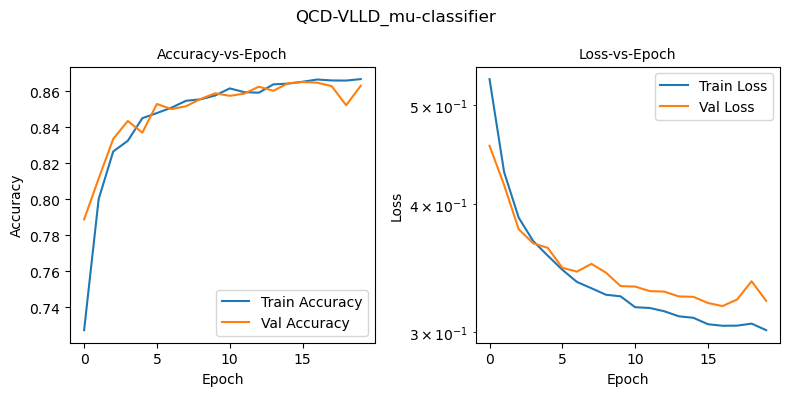

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Subplot 1: accuracy vs epoch
ax[0].plot(history.history['accuracy'],     label='Train Accuracy')
ax[0].plot(history.history['val_accuracy'], label='Val Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy-vs-Epoch', fontsize=10)
ax[0].legend(loc='best')

# Subplot 2: loss vs epoch
ax[1].plot(history.history['loss'],     label='Train Loss')
ax[1].plot(history.history['val_loss'], label='Val Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_yscale('log')
ax[1].legend(loc='best')
ax[1].set_title('Loss-vs-Epoch', fontsize=10)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/loss-and-accuracy.png')
plt.show()

### Using the trained model to predict

In [21]:
%%time

y_predicted_train = model.predict(X_train)
y_predicted_test  = model.predict(X_test)

df_train['score'] = y_predicted_train
df_test['score']  = y_predicted_test

# ROC information for the test dataset
fpr, tpr, _ = roc_curve(y_test, y_predicted_test)
auc_score = auc(tpr,1-fpr)
tpr=tpr*100
fnr=(1-fpr)*100

# ROC information for training data
fpr1, tpr1, _ = roc_curve(y_train, y_predicted_train)
auc_score1 = auc(tpr1,1-fpr1)
tpr1=tpr1*100
fnr1=(1-fpr1)*100

print('Done!\n')

180/180 [==============================] - 1s 3ms/step
Done!

CPU times: user 11.7 s, sys: 14.7 s, total: 26.4 s
Wall time: 3.55 s


### Performance check

In [22]:
display(df_test)

,channel,nlep,njet,nbjet,lep0_pt,lep0_eta,lep0_phi,lep0_iso,lep0_sip3d,lep0_mt,...,jec,jer,wt_leptonSF,wt_trig,wt_bjet,weight,truth,sample,subsample,score
0,0,2,0,0,84.926514,-1.148926,1.959961,0.179829,0.203125,246.205627,...,1.0,1.000000,0.986763,0.950463,1.000000,0.937881,1,VLLD_mu,M100,0.981340
1,0,2,0,0,37.553089,-2.045410,1.020996,0.037698,3.371094,132.263718,...,1.0,1.000000,0.969681,0.968085,1.000000,0.938733,1,VLLD_mu,M100,0.922734
2,0,2,4,1,52.246956,-1.132568,-0.903198,0.419350,0.797363,9.229036,...,1.0,1.021366,0.981145,0.997546,1.000000,0.978738,0,QCD_MuEnriched,170to300,0.039475
3,0,2,2,0,40.715332,0.073044,-2.999512,0.500163,1.876953,56.428967,...,1.0,1.034539,0.971629,0.958171,1.000000,0.930986,0,QCD_MuEnriched,80to120,0.439133
4,0,2,1,0,28.960203,1.276123,-1.791016,0.628567,7.375000,47.657898,...,1.0,0.997733,0.985761,0.950463,1.000000,0.936930,0,QCD_MuEnriched,50to80,0.282999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5724,0,2,3,0,28.987129,-1.352783,1.612793,0.292165,9.062500,4.954614,...,1.0,0.999674,0.950889,0.950463,1.000000,0.903785,0,QCD_MuEnriched,170to300,0.021451
5725,0,2,1,0,129.643204,-1.698975,-1.440430,0.029081,3.177734,2.115742,...,1.0,1.043403,0.967441,0.997806,0.831686,0.965319,0,QCD_MuEnriched,470to600,0.007731
5726,0,2,1,0,80.758759,1.775391,0.824829,0.009924,0.644043,35.834846,...,1.0,1.018502,0.979758,0.953162,0.941765,0.933868,1,VLLD_mu,M100,0.347827
5727,0,2,2,0,356.381195,-0.239044,-2.248535,0.004741,0.610840,543.739197,...,1.0,1.013764,0.982864,0.997546,0.796179,0.980452,1,VLLD_mu,M800,0.983041


In [23]:
%%capture

mybins = np.arange(0, 1.02, 0.02)
density_ = False

def extract_plot(df_, truth_, mybins, density_):
    scores_ = df_[df_['truth'] == truth_]['score']
    hist_ = plt.hist(scores_, bins=mybins, density=density_)
    counts_, bins_, _ = hist_
    errors_ = np.sqrt(counts_)
    integral_ = np.sum(counts_)
    scale_ = integral_ / len(scores_) if len(scores_) > 0 else 1
    weights_ = np.ones_like(scores_)
    if density_ == True: weights_ = np.ones_like(scores_) * (scale_ / len(scores_)) #Normalise integral to 1    
    return scores_, bins_, weights_, counts_, errors_

train_scores_sig, bins_sig_train, weights_sig_train, counts_sig_train, errors_sig_train = extract_plot(df_train, 1, mybins, density_)
train_scores_bkg, bins_bkg_train, weights_bkg_train, counts_bkg_train, errors_bkg_train = extract_plot(df_train, 0, mybins, density_)
test_scores_sig, bins_sig_test, weights_sig_test, counts_sig_test, errors_sig_test =      extract_plot(df_test,  1, mybins, density_)
test_scores_bkg, bins_bkg_test, weights_bkg_test, counts_bkg_test, errors_bkg_test =      extract_plot(df_test,  0, mybins, density_)

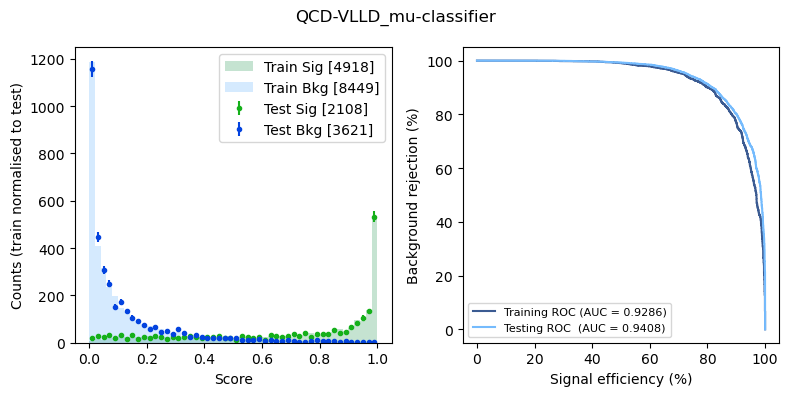

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

decorate_hist = {
    'bins':mybins,
    'histtype':'step',
    'linewidth':1.5,
    'density': density_,
    'log': False,
    'alpha':1.0
}

decorate_point ={
    'marker':'o',
    'markersize':3,
    'linestyle':''
}

if density_:
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', alpha=0.3, bins=mybins, density=density_)
    ax[0].hist(test_scores_sig,  color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', **decorate_hist)
    ax[0].hist(test_scores_bkg,  color='xkcd:blue',  label=f'Test Bkg [{len(test_scores_bkg)}]',**decorate_hist)

else:
    # Calculate the scaling factors to normalize train histograms to match test integrals
    scale_factor_sig = np.sum(counts_sig_test) / np.sum(counts_sig_train) if np.sum(counts_sig_train) > 0 else 1
    scale_factor_bkg = np.sum(counts_bkg_test) / np.sum(counts_bkg_train) if np.sum(counts_bkg_train) > 0 else 1

    # Make train plots, normalized to match test histogram integrals
    ax[0].hist(train_scores_sig, color='xkcd:greenish', label=f'Train Sig [{len(train_scores_sig)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_sig) * scale_factor_sig)
    ax[0].hist(train_scores_bkg, color='xkcd:sky blue', label=f'Train Bkg [{len(train_scores_bkg)}]', 
               alpha=0.3, bins=mybins, density=False, weights=np.ones_like(train_scores_bkg) * scale_factor_bkg)
    
    # Make test plots with error bars
    ax[0].errorbar(bins_sig_test[:-1] + np.diff(bins_sig_test) / 2, 
                   counts_sig_test, 
                   yerr=errors_sig_test, 
                   color='xkcd:green', label=f'Test Sig [{len(test_scores_sig)}]', 
                   fmt='o', markersize=3)
    
    ax[0].errorbar(bins_bkg_test[:-1] + np.diff(bins_bkg_test) / 2, 
                   counts_bkg_test, 
                   yerr=errors_bkg_test, 
                   color='xkcd:blue', label=f'Test Bkg [{len(test_scores_bkg)}]', 
                   fmt='o', markersize=3)

ax[0].set_xlabel('Score')
if density_:     ax[0].set_ylabel('Counts (normalized)')
if not density_: ax[0].set_ylabel('Counts (train normalised to test)')
ax[0].legend(loc='best')

ax[1].plot(tpr, fnr, color='xkcd:denim blue', label='Training ROC (AUC = %0.4f)' % auc_score)
ax[1].plot(tpr1,fnr1,color='xkcd:sky blue',   label='Testing ROC  (AUC = %0.4f)'  % auc_score1)
ax[1].set_xlabel('Signal efficiency (%)')
ax[1].set_ylabel('Background rejection (%)')
ax[1].legend(loc='best', fontsize=8)

fig.suptitle(modelname, fontsize=12)

plt.tight_layout()
plt.savefig(f'{modelname}/performance.png')
plt.show()

### Permutation importance of the training variables

In [25]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import warnings
import io
from contextlib import redirect_stdout, redirect_stderr
warnings.filterwarnings("ignore")

# Define a scoring function compatible with permutation_importance
def keras_accuracy(model, X, y):
    # Get predictions
    y_pred = model.predict(X)
    if y_pred.shape[1] == 1:  # Binary classification case
        y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Threshold at 0.5
    else:  # Multi-class classification case
        y_pred_classes = np.argmax(y_pred, axis=1)
    return accuracy_score(y, y_pred_classes)

f = io.StringIO()
with redirect_stdout(f), redirect_stderr(f): # Suppressing evaluation output
    # Calculate permutation importance
    result = permutation_importance(
        model,
        X_test,
        y_test,
        n_repeats=30,
        random_state=42,
        n_jobs=-1,
        scoring=keras_accuracy
    )

2024-09-26 17:12:27.584077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 17:12:27.597252: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 17:12:27.642610: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26

180/180 [==============================] - 0s 794us/step


Sorted Features and Importance Scores:
HT                   0.282
HTMETllpt            0.142
dilep_mt             0.125
dilep_dR             0.050
njet                 0.046
dilep_dphi           0.042
dphi_metlep_min      0.031
dphi_metlep_max      0.028
dphi_metlep0         0.023
dphi_metdilep        0.020
STfrac               0.009


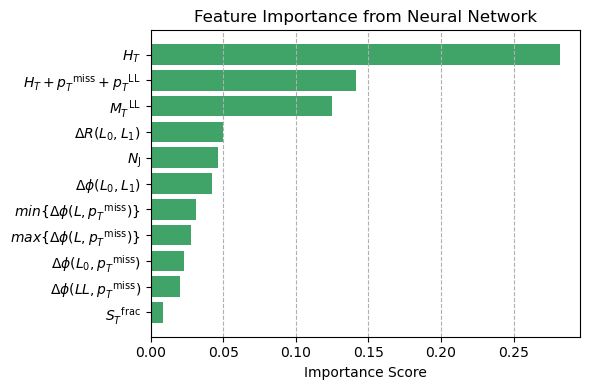

In [26]:
# Get feature importance scores and corresponding variable names
importance_scores = result.importances_mean
feature_names = train_var

# Sort importance scores and corresponding feature names
sorted_indices = np.argsort(importance_scores)[::-1]  # Indices for sorting from most to least
sorted_importance_scores = importance_scores[sorted_indices]
sorted_feature_names = np.array(feature_names)[sorted_indices]
# Apply LaTeX aliases to the sorted feature names
sorted_feature_names_latex = [latexname(name, alias_) for name in sorted_feature_names]

# Print the sorted features and importance scores
print("Sorted Features and Importance Scores:")
for name, score in zip(sorted_feature_names, sorted_importance_scores):
    print(f"{name:<20} {score:.3f}")

# Prepare the plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.barh(sorted_feature_names_latex, sorted_importance_scores, color='xkcd:greenish')  # Use LaTeX aliases
ax.invert_yaxis()
ax.set_xlabel('Importance Score')
#ax.set_ylabel('Features')
ax.set_title('Feature Importance from Neural Network')
ax.grid(axis='x', linestyle='--')

# Save and show the plot
plt.tight_layout()
plt.savefig(f'{modelname}/feature_importance.png', bbox_inches='tight')  # Save with tight bounding box
plt.show()
